In [2]:
library(tidyverse)
library(tidymodels)
library(vip) # For variable importance plots

# Load clean data
df <- read_rds("../data/telecom_churn_clean.rds")

# Fix random seed for reproducibility
set.seed(123)

# Split data (75% training, 25% testing)
data_split <- initial_split(df, prop = 0.75, strata = Churn)
train_data <- training(data_split)
test_data  <- testing(data_split)

print(paste("Training set size:", nrow(train_data)))
print(paste("Testing set size:", nrow(test_data)))

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.6
✔ forcats   1.0.1     ✔ stringr   1.6.0
✔ ggplot2   4.0.1     ✔ tibble    3.3.1
✔ lubridate 1.9.4     ✔ tidyr     1.3.2
✔ purrr     1.2.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.4.1 ──

✔ broom        1.0.11     ✔ rsample      1.3.1 
✔ dials        1.4.2      ✔ tailor       0.1.0 
✔ infer        1.1.0      ✔ tune         2.0.1 
✔ modeldata    1.5.1      ✔ workflows    1.3.0 
✔ parsnip      1.4.1      ✔ workflowsets 1.1.1 
✔ recipes      1.3.1      ✔ yardstick    1.3.2 

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() mask

[1] "Training set size: 5273"
[1] "Testing set size: 1759"


In [3]:
# Define the recipe
churn_recipe <- recipe(Churn ~ ., data = train_data) %>%
  step_dummy(all_nominal_predictors()) %>% # Convert categories to 0/1 columns
  step_zv(all_predictors()) %>%            # Remove columns with single value (zero variance)
  step_normalize(all_numeric_predictors()) # Normalize numbers (helpful for Logistic Regression)

# Check if recipe works (optional, just to verify)
prep(churn_recipe) %>% bake(new_data = NULL) %>% glimpse()

Rows: 5,273
Columns: 31
$ tenure                                <dbl> -1.28843976, 0.05624188, -0.9217…
$ MonthlyCharges                        <dbl> -1.17108724, -0.27219300, -1.174…
$ TotalCharges                          <dbl> -1.0018901, -0.1838634, -0.88222…
$ Churn                                 <fct> No, No, No, No, No, No, No, No, …
$ gender_Male                           <dbl> -1.0200183, 0.9801886, -1.020018…
$ SeniorCitizen_Yes                     <dbl> -0.4426349, -0.4426349, -0.44263…
$ Partner_Yes                           <dbl> 1.0309158, -0.9698273, -0.969827…
$ Dependents_Yes                        <dbl> -0.6531436, -0.6531436, -0.65314…
$ PhoneService_Yes                      <dbl> -3.0962130, 0.3229139, -3.096213…
$ MultipleLines_No.phone.service        <dbl> 3.0962130, -0.3229139, 3.0962130…
$ MultipleLines_Yes                     <dbl> -0.8673331, -0.8673331, -0.86733…
$ InternetService_Fiber.optic           <dbl> -0.8962138, -0.8962138, -0.89621…
$ InternetServic

In [4]:
# 1. Define Model
lr_spec <- logistic_reg() %>%
  set_engine("glm") %>%
  set_mode("classification")

# 2. Create Workflow (Recipe + Model)
lr_workflow <- workflow() %>%
  add_recipe(churn_recipe) %>%
  add_model(lr_spec)

# 3. Fit Model
lr_fit <- lr_workflow %>% fit(data = train_data)

print("Logistic Regression trained!")

[1] "Logistic Regression trained!"


In [5]:
# 1. Define Model
rf_spec <- rand_forest(trees = 500) %>%
  set_engine("ranger", importance = "impurity") %>% # 'impurity' lets us check variable importance later
  set_mode("classification")

# 2. Create Workflow
rf_workflow <- workflow() %>%
  add_recipe(churn_recipe) %>%
  add_model(rf_spec)

# 3. Fit Model (This might take 30 seconds)
rf_fit <- rf_workflow %>% fit(data = train_data)

print("Random Forest trained!")

[1] "Random Forest trained!"


In [6]:
# Function to evaluate a model
evaluate_model <- function(model_fit, model_name) {
  predictions <- model_fit %>%
    predict(test_data) %>%
    bind_cols(predict(model_fit, test_data, type = "prob")) %>%
    bind_cols(test_data %>% select(Churn))
  
  # Calculate AUC
  auc <- roc_auc(predictions, truth = Churn, .pred_Yes) %>% pull(.estimate)
  # Calculate Accuracy
  acc <- accuracy(predictions, truth = Churn, .pred_class) %>% pull(.estimate)
  
  print(paste(model_name, "- AUC:", round(auc, 3), "| Accuracy:", round(acc, 3)))
  
  return(predictions)
}

# Evaluate both
lr_preds <- evaluate_model(lr_fit, "Logistic Regression")
rf_preds <- evaluate_model(rf_fit, "Random Forest")

[1] "Logistic Regression - AUC: 0.143 | Accuracy: 0.825"
[1] "Random Forest - AUC: 0.148 | Accuracy: 0.809"


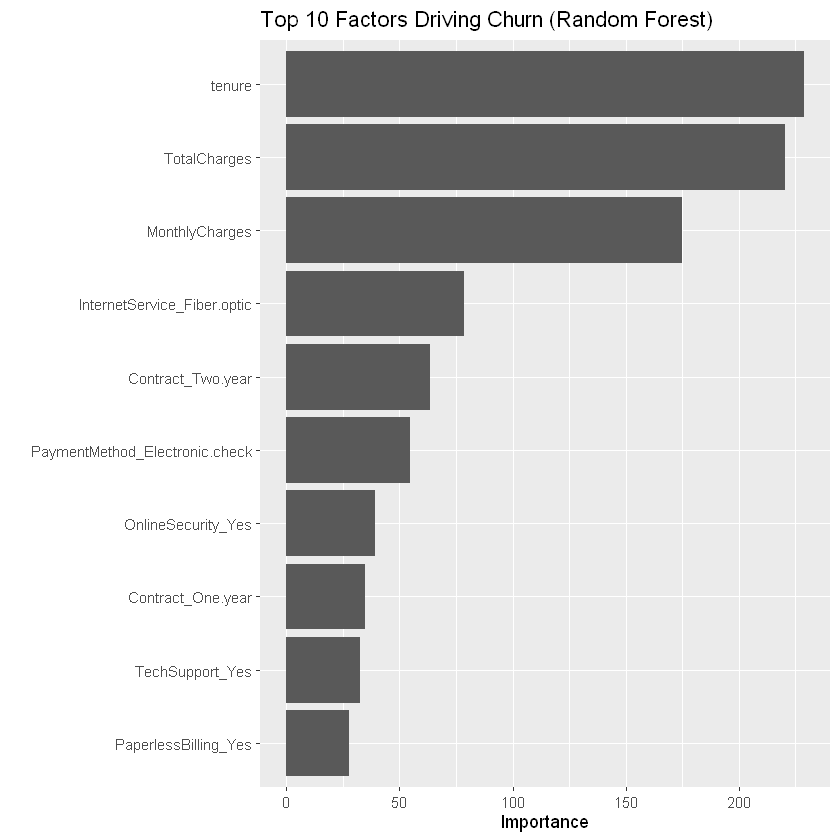

In [7]:
# Extract variable importance from Random Forest
p_imp <- rf_fit %>% 
  extract_fit_parsnip() %>% 
  vip(num_features = 10) +
  labs(title = "Top 10 Factors Driving Churn (Random Forest)")

# Save and Show
ggsave("../results/feature_importance.png", p_imp, width = 8, height = 5)
print(p_imp)

In [8]:
# Function to evaluate a model (CORRECTED)
evaluate_model <- function(model_fit, model_name) {
  predictions <- model_fit %>%
    predict(test_data) %>%
    bind_cols(predict(model_fit, test_data, type = "prob")) %>%
    bind_cols(test_data %>% select(Churn))
  
  # Calculate AUC (Explicitly telling R that 'Yes' is our target)
  auc <- roc_auc(predictions, truth = Churn, .pred_Yes, event_level = "second") %>% pull(.estimate)
  
  # Calculate Accuracy
  acc <- accuracy(predictions, truth = Churn, .pred_class) %>% pull(.estimate)
  
  print(paste(model_name, "- AUC:", round(auc, 3), "| Accuracy:", round(acc, 3)))
  
  return(predictions)
}

# Evaluate both
lr_preds <- evaluate_model(lr_fit, "Logistic Regression")
rf_preds <- evaluate_model(rf_fit, "Random Forest")

[1] "Logistic Regression - AUC: 0.857 | Accuracy: 0.825"
[1] "Random Forest - AUC: 0.852 | Accuracy: 0.809"
